In [38]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR 

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential, load_model

import warnings
warnings.simplefilter(action='ignore')

In [15]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 6) 
sns.set(context="paper", font="monospace") 

In [128]:
def forecast_plot(df1, df2, pred, names, model_name):
    fig = make_subplots(rows=6, cols=1, subplot_titles=df1.columns,
                    vertical_spacing=0.05)

    for i, col in enumerate(df.columns):
        fig.add_trace(go.Scatter(name=names[0], x=df1.index, y=df1[col],  
                                marker = dict(size = 10, 
                                            color = 'blue'),
                                textfont=dict(
                                    color='black',
                                    size=18,  
                                    family='Times New Roman')),
                    row=i+1, col=1)
        fig.add_trace(go.Scatter(name=names[1], x=df2.index, y=df2[col],  
                                marker = dict(size = 10, 
                                            color = 'red')),
                    row=i+1, col=1) 
        fig.add_trace(go.Scatter(name=names[2], x=df2.index, y=pred[:, i],  
                                marker = dict(size = 10, 
                                            color = 'green')),
                    row=i+1, col=1) 
        
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.update_layout(autosize=False,
        width=1300,
        height=1500,
        title={
            'text': f"{model_name} Model Plot",
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top', 
            'font': {'size': 20}}
        )
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show() 

In [17]:
def rmse_results(actual, pred):
    result = dict()
    # check rmse
    for i, col in enumerate(df.columns):
        result[f'{col} RMSE'] = np.sqrt(mean_squared_error(actual[:, i], pred[:, i])).round(3)
    return result

## Data Preparation

In [18]:
df = pd.read_csv('datasets/throughput_metrics.csv', parse_dates=['Time'], index_col='Time')
print(df.shape)
df.head() 

(8760, 6)


SiteA         SiteB         SiteC        SiteD  \
Time                                                                         
2018-01-01 08:00:00  1.411093e+10  1.109243e+09  8.289831e+07  56650005.21   
2018-01-01 09:00:00  1.345362e+10  1.242256e+09  4.375739e+04  49307351.26   
2018-01-01 10:00:00  1.216888e+10  2.006322e+09  4.315725e+04  56843652.59   
2018-01-01 11:00:00  1.123120e+10  1.073181e+09  8.277154e+07  46645240.59   
2018-01-01 12:00:00  1.078085e+10  8.645069e+08  3.343548e+04  30966947.37   

                            SiteE        SiteF  
Time                                            
2018-01-01 08:00:00  1.117868e+07  827420.9772  
2018-01-01 09:00:00  7.070847e+06  913017.6007  
2018-01-01 10:00:00  5.132826e+07  874471.3644  
2018-01-01 11:00:00  5.217827e+06  837246.7783  
2018-01-01 12:00:00  7.495363e+06  827143.7497

In [19]:
df.describe().T

count          mean           std           min           25%  \
SiteA  8760.0  1.134300e+10  5.843792e+09  3.227624e+08  7.677623e+09   
SiteB  8760.0  1.050114e+10  8.509006e+09  0.000000e+00  3.942119e+09   
SiteC  8760.0  2.422851e+07  3.285736e+07  1.013134e+04  4.546207e+04   
SiteD  8760.0  7.645930e+07  6.293577e+07  7.408801e+05  2.792179e+07   
SiteE  8760.0  8.169740e+07  1.297177e+08  0.000000e+00  1.817469e+07   
SiteF  8760.0  1.194613e+06  8.569518e+05  3.786450e+05  8.628346e+05   

                50%           75%           max  
SiteA  1.002482e+10  1.335055e+10  7.553718e+10  
SiteB  8.836137e+09  1.452307e+10  5.229297e+10  
SiteC  8.613927e+04  4.363564e+07  2.513275e+08  
SiteD  5.725981e+07  1.097949e+08  3.593521e+08  
SiteE  5.025162e+07  9.435435e+07  1.578908e+09  
SiteF  9.951363e+05  1.243718e+06  2.659389e+07

`SiteB` and `SiteE` has value 0, would treat them as missing values.

In [20]:
# missing value treatment
for i in ['SiteB', 'SiteE']:
    df[i][df[i] == 0] = df[i].mean() 

In [21]:
df.describe().T

count          mean           std           min           25%  \
SiteA  8760.0  1.134300e+10  5.843792e+09  3.227624e+08  7.677623e+09   
SiteB  8760.0  1.057187e+10  8.464950e+09  6.175849e+02  4.070088e+09   
SiteC  8760.0  2.422851e+07  3.285736e+07  1.013134e+04  4.546207e+04   
SiteD  8760.0  7.645930e+07  6.293577e+07  7.408801e+05  2.792179e+07   
SiteE  8760.0  8.179998e+07  1.296853e+08  1.345571e+06  1.823692e+07   
SiteF  8760.0  1.194613e+06  8.569518e+05  3.786450e+05  8.628346e+05   

                50%           75%           max  
SiteA  1.002482e+10  1.335055e+10  7.553718e+10  
SiteB  8.960706e+09  1.452307e+10  5.229297e+10  
SiteC  8.613927e+04  4.363564e+07  2.513275e+08  
SiteD  5.725981e+07  1.097949e+08  3.593521e+08  
SiteE  5.036699e+07  9.435435e+07  1.578908e+09  
SiteF  9.951363e+05  1.243718e+06  2.659389e+07

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


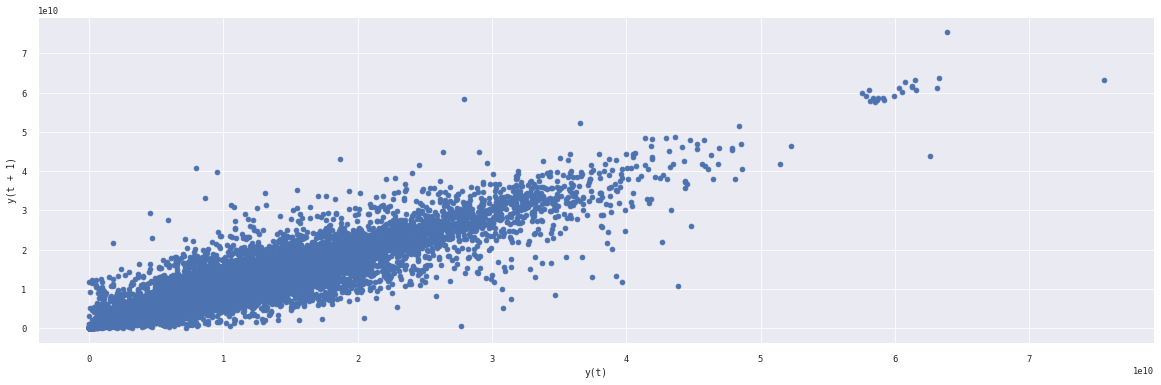

In [67]:
# fig, (ax1, ax2) = plt.subplots(2, 1)
# df.plot(ax=ax1)
pd.plotting.lag_plot(df)
plt.show() 

In [22]:
# checking stationarity 
cj_stat = coint_johansen(df,-1,1).eig 
print(cj_stat) 

[0.38781877 0.16825603 0.07957321 0.04127049 0.0269346  0.0051296 ]


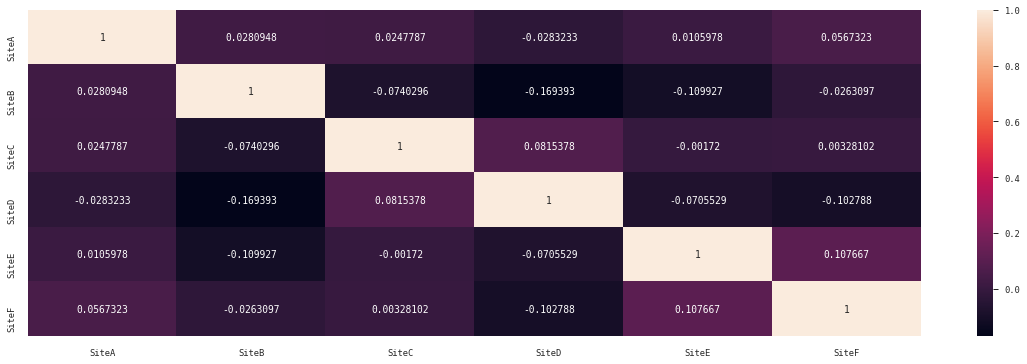

In [23]:
sns.heatmap(df.corr(), fmt='g', annot=True); 

## VAR

In [70]:
# forecast for next 65 days 
n_obs = 65 * 24
df_train, df_test = df[0:-n_obs], df[-n_obs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(7200, 6)
(1560, 6)


In [90]:
# fit the model
model = VAR(endog=df_train)
model_fit = model.fit() 
# model_fit.summary()

In [91]:
# Get the lag order
lag_order = model_fit.k_ar
print(lag_order) 

1


In [92]:
# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input.shape  

(1, 6)

In [93]:
# Forecast
fc = model_fit.forecast(y=forecast_input, steps=n_obs)
fc.shape 

(1560, 6)

In [131]:
# calculate RMSE
var_result = rmse_results(df_test.values, fc)
var_result 

{'SiteA RMSE': 8276580039.877,
 'SiteB RMSE': 11910810610.776,
 'SiteC RMSE': 25672480.24,
 'SiteD RMSE': 54453919.684,
 'SiteE RMSE': 58671447.163,
 'SiteF RMSE': 606746.135}

In [129]:
forecast_plot(df_train, df_test, fc, ['Train', 'Test', 'Predict'], 'VAR') 

## LSTM

In [34]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg 

In [48]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
df_reframed = series_to_supervised(scaled) 
df_reframed 

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.183318   0.021212   0.329815   0.155905   0.006233   0.017119   
2      0.174579   0.023756   0.000134   0.135429   0.003629   0.020384   
3      0.157498   0.038367   0.000131   0.156445   0.031683   0.018914   
4      0.145031   0.020522   0.329310   0.128006   0.002455   0.017494   
5      0.139044   0.016532   0.000093   0.084286   0.003898   0.017108   
...         ...        ...        ...        ...        ...        ...   
8755   0.058520   0.180123   0.000215   0.131029   0.029267   0.018803   
8756   0.049302   0.157126   0.160575   0.162244   0.006522   0.019388   
8757   0.103426   0.163118   0.166855   0.143684   0.004971   0.018962   
8758   0.095815   0.157771   0.000139   0.148728   0.034576   0.018967   
8759   0.087243   0.184103   0.000251   0.172668   0.038146   0.019103   

       var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1     0.174579  0.023756  0.000134  0.135429  0.003629  0.020384  
2     0.157498  0.038367  0.000131  0.156445  0.031683  0.018914  
3     0.145031  0.020522  0.329310  0.128006  0.002455  0.017494  
4     0.139044  0.016532  0.000093  0.084286  0.003898  0.017108  
5     0.138376  0.040076  0.000687  0.135176  0.002600  0.017347  
...        ...       ...       ...       ...       ...       ...  
8755  0.049302  0.157126  0.160575  0.162244  0.006522  0.019388  
8756  0.103426  0.163118  0.166855  0.143684  0.004971  0.018962  
8757  0.095815  0.157771  0.000139  0.148728  0.034576  0.018967  
8758  0.087243  0.184103  0.000251  0.172668  0.038146  0.019103  
8759  0.111053  0.234833  0.000251  0.154925  0.006103  0.020183  

[8759 rows x 12 columns]

In [49]:
# split into train and test sets
values = df_reframed.values
n_train_hours = 300 * 24 # first 300 days for train 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-6], train[:, -6:]
test_X, test_y = test[:, :-6], test[:, -6:] 
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(7200, 1, 6) (7200, 6) (1559, 1, 6) (1559, 6)


In [60]:
lstm_model = load_model('models/LSTM.h5') 

In [61]:
# make prediction
yhat = lstm_model.predict(test_X)

In [62]:
# invert scaling for forecast and actual 
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

In [63]:
# calculate RMSE
lstm_result = rmse_results(inv_y, inv_yhat)
lstm_result

{'SiteA RMSE': 4172149281.57,
 'SiteB RMSE': 3031441726.149,
 'SiteC RMSE': 23142495.027,
 'SiteD RMSE': 14382751.311,
 'SiteE RMSE': 37918552.737,
 'SiteF RMSE': 607678.896}

In [130]:
df_train, df_test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]
forecast_plot(df_train, df_test, inv_yhat, ['Train', 'Test', 'Predict'], 'LSTM') 